https://www.kaggle.com/code/imthebaron/bengali-ai-grapheme-classification?scriptVersionId=198759523

In [1]:
import os
import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import measure

import cv2
from tqdm import tqdm

In [2]:
tf.random.set_seed(42)

In [3]:
load_dir = '/kaggle/input/bengaliai/256_train/256/'

train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
train.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

In [4]:
train['filename'] = train.image_id.apply(lambda filename: load_dir + filename + '.png')
train = train[:50000]
len(train)

50000

In [5]:
train.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme  \
0  Train_0             15                9                    5   ক্ট্রো   
1  Train_1            159                0                    0        হ   
2  Train_2             22                3                    5     খ্রী   
3  Train_3             53                2                    2     র্টি   
4  Train_4             71                9                    5     থ্রো   

                                            filename  
0  /kaggle/input/bengaliai/256_train/256/Train_0.png  
1  /kaggle/input/bengaliai/256_train/256/Train_1.png  
2  /kaggle/input/bengaliai/256_train/256/Train_2.png  
3  /kaggle/input/bengaliai/256_train/256/Train_3.png  
4  /kaggle/input/bengaliai/256_train/256/Train_4.png

In [6]:
train_df = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
print(f'Size of training data: {train_df.shape}')
train_df.head()

Size of training data: (200840, 5)


image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

In [7]:
print(f'Number of unique graphemes: {train_df["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df["consonant_diacritic"].nunique()}')

Number of unique graphemes: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


In [8]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - np.array(im.shape[:2])
    t, b = pad_diff[0] // 2, (pad_diff[0] + 1) // 2
    l, r = pad_diff[1] // 2, (pad_diff[1] + 1) // 2
    return ((t, b), (l, r), (0, 0)) if is_rgb else ((t, b), (l, r))

def crop_object(img, thresh=220, maxval=255, square=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh_gray = cv2.threshold(gray, thresh, maxval, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    x, y, w, h = max([cv2.boundingRect(c) for c in contours], key=lambda b: b[2]*b[3])
    crop = img[y:y+h, x:x+w]

    if square:
        pad_width = get_pad_width(crop, max(crop.shape[:2]), is_rgb=(img.ndim == 3))
        crop = np.pad(crop, pad_width=pad_width, mode='constant', constant_values=255)
    
    return crop

In [9]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    #preprocessing_function= tf.keras.applications.efficientnet.preprocess_input
)

In [10]:
def data_generator(filenames, y, batch_size=128, shape=(64, 64, 1), random_state=42, preprocess=False, augmentation=False):
    y = y.copy()
    np.random.seed(random_state)
    indices = np.arange(len(filenames))

    while True:
        np.random.shuffle(indices)

        for i in range(0, len(indices), batch_size):
            batch_idx = indices[i:i + batch_size]
            size = len(batch_idx)

            batch_files = filenames[batch_idx]
            X_batch = np.zeros((size, *shape), dtype=np.float32)
            y_batch = y[batch_idx]

            for j, file in enumerate(batch_files):
                #print(file)
                img = cv2.imread(file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

                if preprocess:
                    img = crop_object(img, thresh=250)  # Ensure img is still RGB
                    img = cv2.resize(img, shape[:2])  # Resize to (64, 64)
                else:
                    img = cv2.resize(img, shape[:2])  # Resize to (64, 64)

                if augmentation:
                    img = datagen.random_transform(img)

                # Convert the RGB image to grayscale
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                # Reshape to add a channel dimension
                img = img.reshape(*shape)  # Now shape is (64, 64, 1)

                X_batch[j] = img / 255.0  # Normalize pixel values to [0, 1]

            # Convert target labels from list of arrays to a tuple of arrays
            y_batch_tuple = tuple([y_batch[:, i] for i in range(y_batch.shape[1])])

            # Yield the batch and labels
            yield X_batch, y_batch_tuple

In [11]:
train_files, valid_files, y_train, y_valid = train_test_split(
    train.filename.values, 
    train[['grapheme_root','vowel_diacritic', 'consonant_diacritic']].values, 
    test_size=0.25, 
)

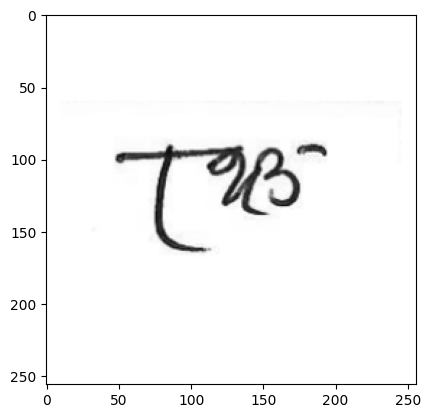

In [12]:
image = cv2.cvtColor(cv2.imread('/kaggle/input/bengaliai/256_train/256/Train_200000.png'), cv2.COLOR_BGR2RGB)
plt.imshow(image)

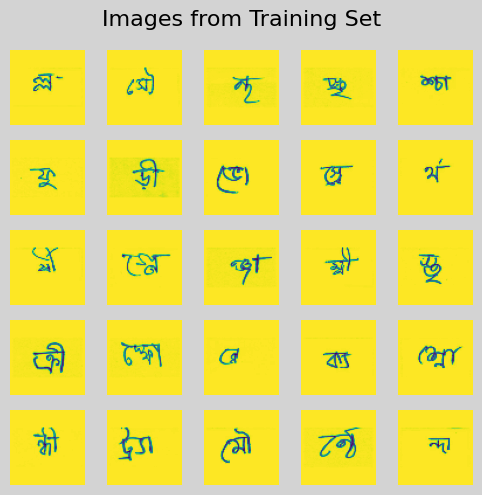

In [13]:
#generator = data_generator(train_files, y_train, preprocess=False, augmentation=False)
generator = data_generator(train_files, y_train)
X_batch, _ = next(generator)

fig, axes = plt.subplots(5, 5, figsize=(5, 5), facecolor='lightgray')
axes = axes.flatten()

for img, ax in zip(X_batch, axes):
    ax.imshow(np.squeeze(img))  # Squeeze the image and use grayscale colormap
    ax.axis('off')  # Hide axis

plt.suptitle('Images from Training Set', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for the title

# Save the figure
plt.savefig('sample_images.png', bbox_inches='tight', dpi=400)
plt.show()

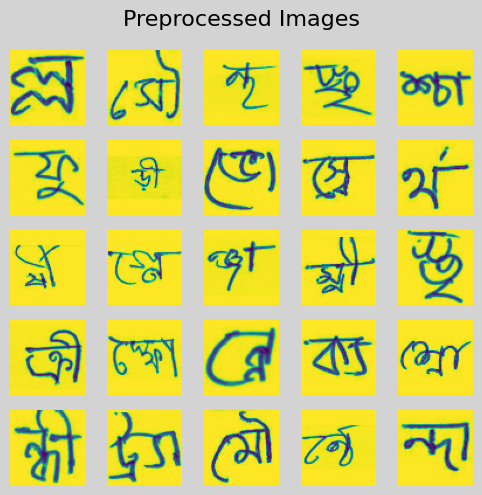

In [14]:
# Usage of the generator
#generator = data_generator(train_files, y_train, preprocess=True, augmentation=False)
generator = data_generator(train_files, y_train, preprocess=True, augmentation=False)
X_batch, _ = next(generator)

fig, axes = plt.subplots(5, 5, figsize=(5, 5), facecolor='lightgray')
axes = axes.flatten()

for img, ax in zip(X_batch, axes):
    ax.imshow(img)  # Display the RGB image
    ax.axis('off')  # Hide axis

plt.suptitle('Preprocessed Images', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for the title

# Save the figure
plt.savefig('preprocessed.png', bbox_inches='tight', dpi=400)
plt.show()

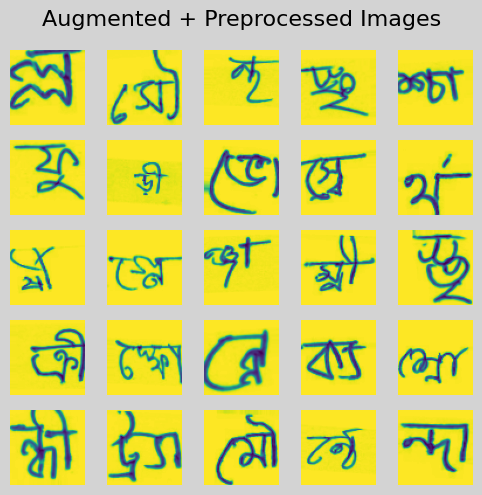

In [15]:
# Usage of the generator
#generator = data_generator(train_files, y_train, preprocess=True, augmentation=True)
generator = data_generator(train_files, y_train, preprocess=True, augmentation=True)
X_batch, _ = next(generator)

fig, axes = plt.subplots(5, 5, figsize=(5, 5), facecolor='lightgray')
axes = axes.flatten()

for img, ax in zip(X_batch, axes):
    ax.imshow(img)  # Display the RGB image
    ax.axis('off')  # Hide axis

plt.suptitle('Augmented + Preprocessed Images', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for the title

# Save the figure
plt.savefig('augmented.png', bbox_inches='tight', dpi=400)
plt.show()

In [16]:
batch_size = 128

#train_gen = data_generator(train_files, y_train, preprocess=True, augmentation=True)
#valid_gen = data_generator(valid_files, y_valid, preprocess=True, augmentation=True)

train_gen = data_generator(train_files, y_train, preprocess=True, augmentation=True)
valid_gen = data_generator(valid_files, y_valid, preprocess=True, augmentation=True)
                           
print((len(train_files) , len(valid_files)))

train_steps = len(train_files) // batch_size
valid_steps = len(valid_files) // batch_size

(37500, 12500)


In [17]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def bengali_ai():
    inputs = Input(shape=(64, 64, 1))

    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(inputs)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Dropout(rate=0.2)(x)

    x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Dropout(rate=0.2)(x)

    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.2)(x)

    # Dense Layers
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization(momentum=0.5)(x)

    # Output Layers
    root_out = layers.Dense(168, activation='softmax', name='grapheme')(x)
    vowel_out = layers.Dense(11, activation='softmax', name='vowel')(x)
    consonant_out = layers.Dense(7, activation='softmax', name='consonant')(x)

# Final Model
    model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out], name='bengali.ai')

    return model

model = bengali_ai()
model.summary()

Model: "bengali.ai"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 64, 64,    │         73 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 64, 64,    │      1,344 │ separable_conv2d… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 32, 32,    │      2,400 │ dropout[0][0]     │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 32, 32,    │      4,736 │ separable_conv2d… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 16, 16,    │      8,896 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5  │ (None, 16, 16,    │     17,664 │ separable_conv2d… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6  │ (None, 8, 8, 128) │     17,664 │ dropout_1[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 8, 8, 256) │     34,176 │ separable_conv2d… │
│ (SeparableConv2D)   │                   │            │                 

 Total params: 684,003 (2.61 MB)

 Trainable params: 680,483 (2.60 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [18]:
tf.keras.utils.plot_model(model, dpi=500, to_file='model.png', show_shapes=True, show_layer_activations=True) # , show_trainable=True

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        'grapheme': 'sparse_categorical_crossentropy',
        'vowel': 'sparse_categorical_crossentropy',
        'consonant': 'sparse_categorical_crossentropy'
    },
    metrics={
        'grapheme': 'accuracy',
        'vowel': 'accuracy',
        'consonant': 'accuracy'
    }
)

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.weights.h5',
    monitor='val_loss',
    mode='min',
    save_freq = 'epoch',
    save_weights_only=True,
    save_best_only=True)

In [21]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    min_delta=0.001,         # Minimum change in monitored value to qualify as improvement
    patience=3,             # Stop after 10 epochs of no improvement
    mode='min',              # Maximize the validation accuracy
    restore_best_weights=True,  # Restore model weights from the best epoch
    verbose=1
)

In [22]:
train_history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/50


I0000 00:00:1727605508.221676      67 service.cc:145] XLA service 0x7ccbac005410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727605508.221732      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/292 ━━━━━━━━━━━━━━━━━━━━ 1:33:33 19s/step - consonant_accuracy: 0.0859 - grapheme_accuracy: 0.0000e+00 - loss: 9.4664 - vowel_accuracy: 0.1172

I0000 00:00:1727605520.892212      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - consonant_accuracy: 0.4885 - grapheme_accuracy: 0.0186 - loss: 9.0135 - vowel_accuracy: 0.2411 - val_consonant_accuracy: 0.6386 - val_grapheme_accuracy: 0.0482 - val_loss: 7.1552 - val_vowel_accuracy: 0.5310
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 265s 877ms/step - consonant_accuracy: 0.6423 - grapheme_accuracy: 0.0591 - loss: 6.8860 - vowel_accuracy: 0.5606 - val_consonant_accuracy: 0.6860 - val_grapheme_accuracy: 0.0955 - val_loss: 6.0600 - val_vowel_accuracy: 0.6570
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 248s 853ms/step - consonant_accuracy: 0.6868 - grapheme_accuracy: 0.0949 - loss: 6.0256 - vowel_accuracy: 0.6541 - val_consonant_accuracy: 0.7262 - val_grapheme_accuracy: 0.1351 - val_loss: 5.4228 - val_vowel_accuracy: 0.7179
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 246s 846ms/step - consonant_accuracy: 0.7229 - grapheme_accuracy: 0.1342 - loss: 5.4687 - vowel_accuracy: 0.6979 - val_consonant_accuracy: 0.7501 - val_grapheme_accuracy: 0.191

In [23]:
train_history.history.keys()

dict_keys(['consonant_accuracy', 'grapheme_accuracy', 'loss', 'vowel_accuracy', 'val_consonant_accuracy', 'val_grapheme_accuracy', 'val_loss', 'val_vowel_accuracy'])

In [24]:
model.save('bengali.ai efficientb0 grayscale.h5')

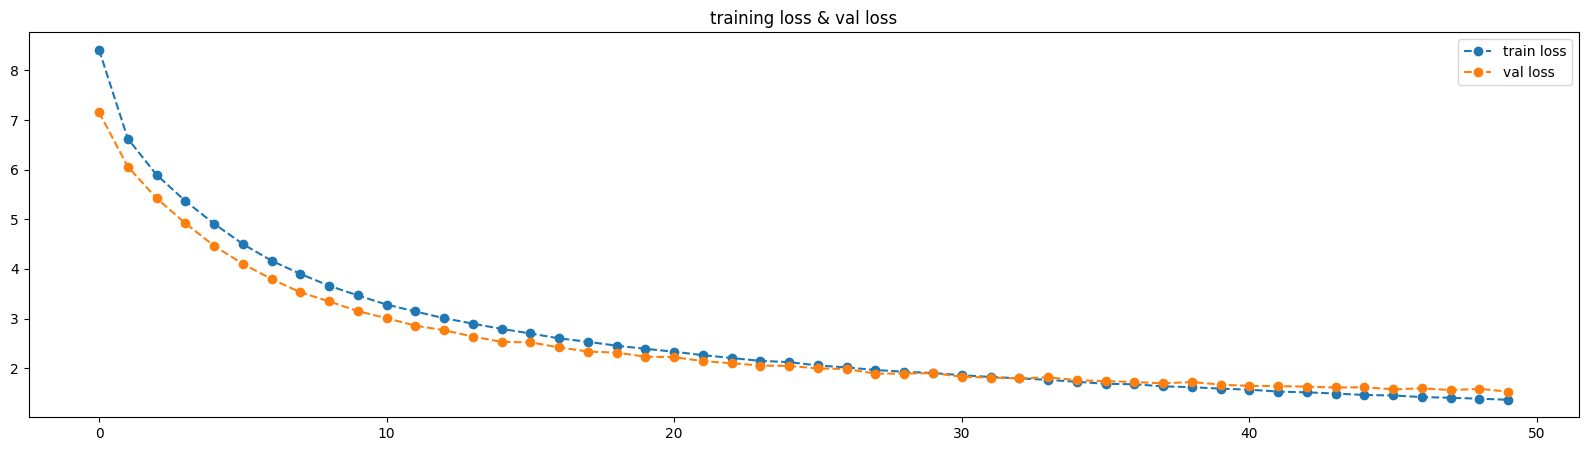

In [25]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history['loss'], '--o', label='train loss')
plt.plot(train_history.history['val_loss'], '--o', label='val loss')
plt.legend()
plt.title('training loss & val loss')
plt.savefig('fig_total_loss.png', format='png', dpi=400)
plt.show()

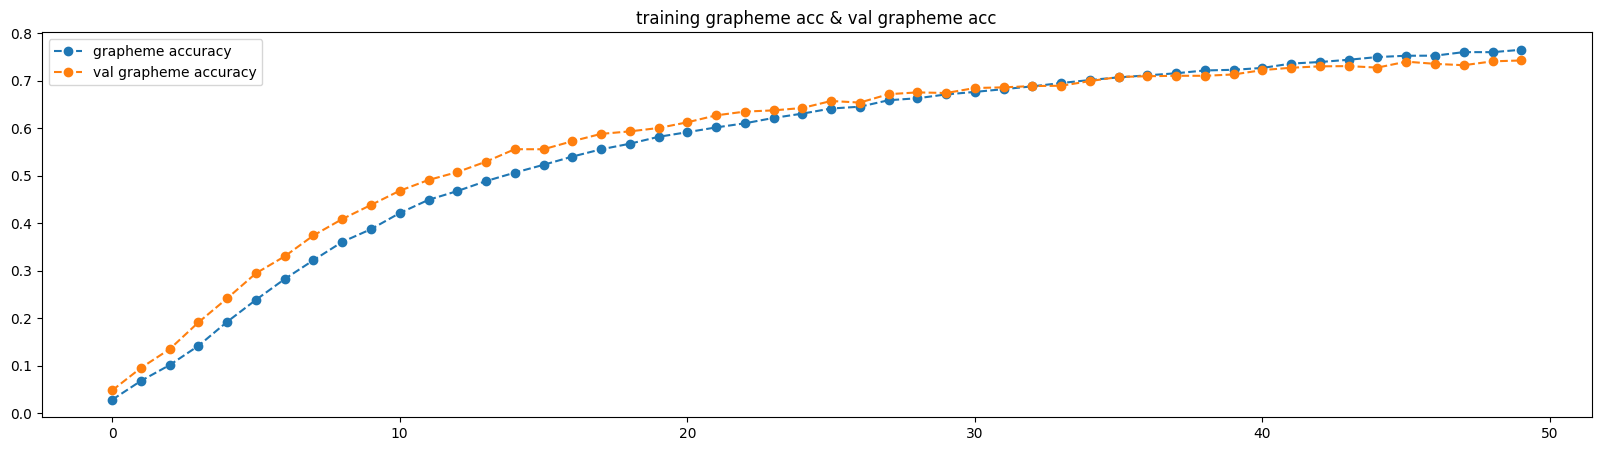

In [26]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history['grapheme_accuracy'], '--o', label='grapheme accuracy')
plt.plot(train_history.history['val_grapheme_accuracy'], '--o', label='val grapheme accuracy')
plt.legend()
plt.title('training grapheme acc & val grapheme acc')
plt.savefig('fig_grapheme_acc.png', format='png', dpi=400)
plt.show()

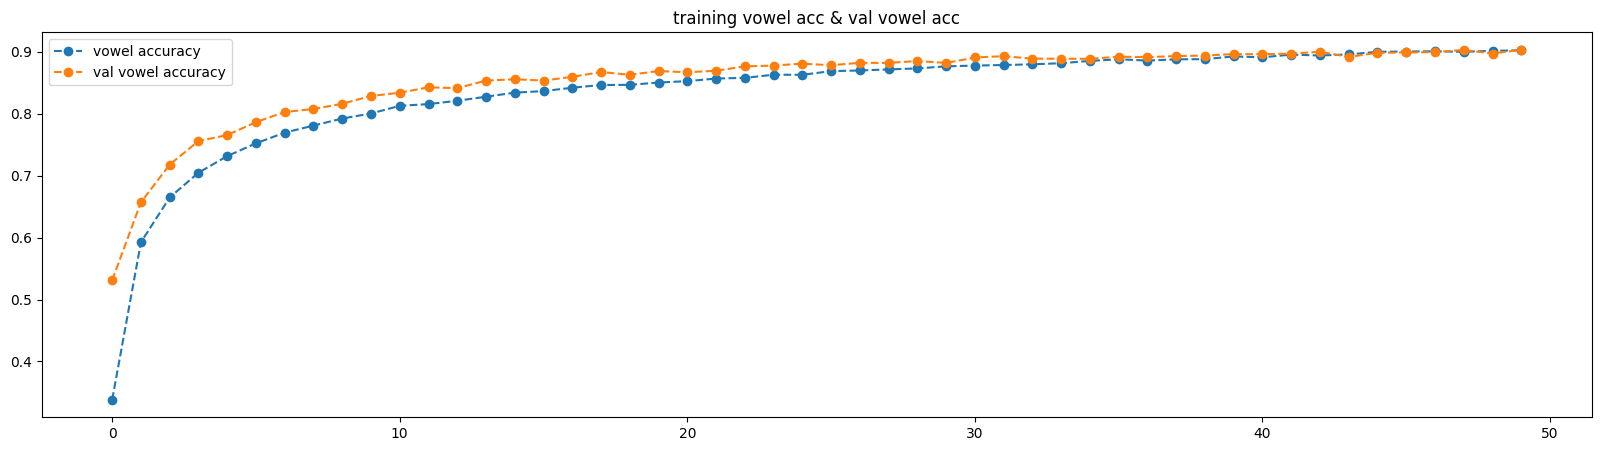

In [27]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history['vowel_accuracy'], '--o', label='vowel accuracy')
plt.plot(train_history.history['val_vowel_accuracy'], '--o', label='val vowel accuracy')
plt.legend()
plt.title('training vowel acc & val vowel acc')
plt.savefig('fig_vowel_acc.png', format='png', dpi=400)
plt.show()

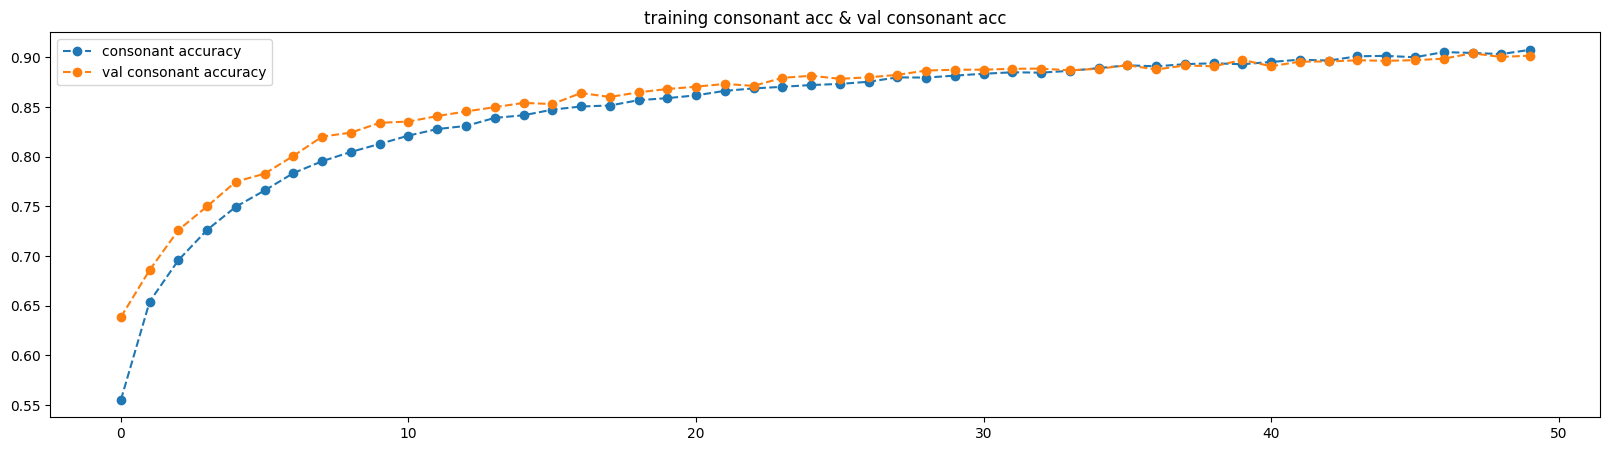

In [28]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history['consonant_accuracy'], '--o', label='consonant accuracy')
plt.plot(train_history.history['val_consonant_accuracy'], '--o', label='val consonant accuracy')
plt.legend()
plt.title('training consonant acc & val consonant acc')
plt.savefig('fig_consonant_acc.png', format='png', dpi=400)
plt.show()

In [29]:
pd.DataFrame(train_history.history).to_csv('history.csv', index=False)

In [30]:
df = pd.read_csv('/kaggle/working/history.csv')
print(df.shape) 
df.head(df.shape[0])

(50, 8)


consonant_accuracy  grapheme_accuracy      loss  vowel_accuracy  \
0             0.555330           0.028494  8.414867        0.338078   
1             0.654180           0.068260  6.624170        0.592502   
2             0.695895           0.101573  5.895066        0.664776   
3             0.726373           0.142031  5.368079        0.704832   
4             0.749652           0.192604  4.910456        0.731564   
5             0.766028           0.238762  4.500738        0.752274   
6             0.783501           0.282564  4.163813        0.769533   
7             0.795435           0.322140  3.899103        0.780905   
8             0.804774           0.360564  3.659889        0.792304   
9             0.812855           0.387349  3.464804        0.800412   
10            0.821203           0.421305  3.280476        0.812801   
11            0.827785           0.449133  3.141440        0.815611   
12            0.830943           0.467516  3.006071        0.821016   
13            0.839051           0.488548  2.896084        0.827518   
14            0.841646           0.506315  2.790509        0.834127   
15            0.847319           0.522771  2.698678        0.836589   
16            0.850503           0.540083  2.599729        0.842048   
17            0.851493           0.555362  2.531016        0.846463   
18            0.856845           0.567136  2.452121        0.846703   
19            0.858905           0.581692  2.389887        0.850423   
20            0.861715           0.591432  2.330431        0.852697   
21            0.866237           0.601440  2.261665        0.856871   
22            0.868698           0.610109  2.204030        0.857969   
23            0.870304           0.621428  2.146985        0.863053   
24            0.872097           0.630472  2.120786        0.862972   
25            0.873194           0.641229  2.053556        0.868806   
26            0.875415           0.645028  2.014699        0.869929   
27            0.879803           0.658675  1.962656        0.871615   
28            0.879589           0.662822  1.927074        0.873247   
29            0.881569           0.670850  1.901775        0.876565   
30            0.883469           0.676175  1.858054        0.877823   
31            0.884914           0.681954  1.822265        0.878706   
32            0.884566           0.687868  1.795150        0.879857   
33            0.886386           0.694852  1.763987        0.881649   
34            0.889115           0.701193  1.724345        0.885369   
35            0.891951           0.706786  1.685136        0.887991   
36            0.890908           0.711014  1.674918        0.885904   
37            0.893129           0.715402  1.633033        0.887884   
38            0.893985           0.721289  1.615831        0.888205   
39            0.893022           0.722680  1.587262        0.892593   
40            0.895349           0.726614  1.566113        0.891175   
41            0.897624           0.735792  1.527811        0.895537   
42            0.896687           0.739056  1.512740        0.894119   
43            0.901076           0.743819  1.488031        0.895804   
44            0.901424           0.749518  1.459330        0.900086   
45            0.900059           0.752248  1.449170        0.900541   
46            0.905277           0.752408  1.417521        0.900835   
47            0.904394           0.759900  1.402664        0.900059   
48            0.903243           0.759767  1.384270        0.901664   
49            0.907578           0.764797  1.362506        0.902440   

    val_consonant_accuracy  val_grapheme_accuracy  val_loss  \
0                 0.638611               0.048244  7.155213   
1                 0.685984               0.095538  6.060030   
2                 0.726156               0.135063  5.422835   
3                 0.750081               0.191400  4.920765   
4                 0.774895               0.241917  4.463911   
5   